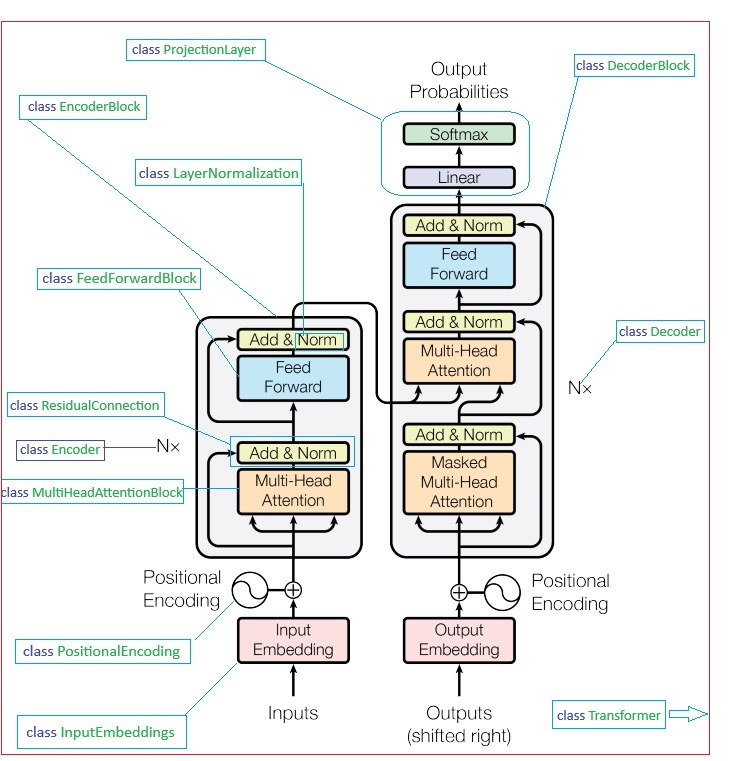

In [2]:
import torch
import torch.nn as nn
import math


In [3]:
class InputEmbeddings(nn.Module):
  def __init__(self, d_model:int, vocab_size:int):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    # (batch, seq_len) --> (batch, seq_len, d_model)
    # Multiply by sqrt(d_model) to scale the embeddings according to the paper
    return self.embedding(x) * math.sqrt(self.d_model)

In [4]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model:int, seq_length:int, dropout:float)->None:
    super().__init__()
    self.seq_length = seq_length
    self.d_model = d_model
    self.dropout = nn.Dropout(dropout)

    #create a tensor of (seq_length, d_model)
    pe = torch.zeros(seq_length, d_model) # self.pe not required - will be registered later

    # create a tensor of shape (seq_length, 1)
    position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)

    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(1000.0)/d_model)) # (d_model / 2)

    # Apply sin to even position and cos to odd position
    pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
    pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))

    # Add a batch dimension to the positional encoding
    pe = pe.unsqueeze(0) # (1, seq_len, d_model)
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + (self.pe[:, :x.size(1), :]).requires_grad_(False) # (batch, seq_len, d_model)
    return self.dropout(x)

In [5]:
class LayerNormalization(nn.Module):
  def __init__(self, eps: float = 10**-6) -> None:
    super().__init__()
    self.eps = eps
    self.alpha = nn.Parameter(torch.ones(1)) # Multiplied
    self.bias = nn.Parameter(torch.ones(1))  # Added

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.alpha * (x - mean) / (std + self.eps) + self.bias

In [6]:
class FeedForwardBlock(nn.Module):
  def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
    super().__init__()
    self.linear1 = nn.Linear(d_model, d_ff) # W1 & B1; Bias is True by default
    self.dropout = nn.Dropout(dropout)
    self.linear2 = nn.Linear(d_ff, d_model) # W2 and B2

  def forward(self, x):
    # (Batch, seq_len, d_model) -> (Batch, seq_len, d_ff)
    x = self.linear1(x)
    x = self.dropout(x)
    # (Batch, seq_len, d_ff) -> (Batch, seq_len, d_model)
    x = self.linear2(x)
    return x

In [7]:
class MultiHeadAttentionBlock(nn.Module):
  def __init__(self, d_model: int, h: int, dropout: float)->None:
    super().__init__()
    self.d_model = d_model
    self.h = h
    assert d_model % h == 0, "d_model is not divisiable by h"

    self.d_k = d_model // h
    self.w_q = nn.Linear(d_model, d_model) #Wq
    self.w_k = nn.Linear(d_model, d_model) #Wk
    self.w_v = nn.Linear(d_model, d_model) #Wv

    self.w_o = nn.Linear(d_model, d_model) #Wo
    self.dropout = nn.Dropout(dropout)

  @staticmethod
  def attention(query, key, value, mask, dropout):
    d_k = query.shape[-1]

    # (Batch, h, seq_len, d_k) @ (Batch, h, d_k, seq_len) ==> (Batch, h, seq_len, seq_len)
    attention_score = (query @ key.transpose(-2, -1))/math.sqrt(d_k)

    # before applying softmax we need to apply mask to hide the interaction among some tokens/word.
    if mask is not None:
      attention_score.masked_fill_(mask == 0, -1e9)
    attention_score = nn.functional.softmax(attention_score, dim=-1) # (Batch, h, seq_len, seq_len)

    if dropout is not None:
      attention_score = dropout(attention_score)

    # shape of `attention_score @ value`: (Batch, h, seq_len, d_k)
    return (attention_score @ value), attention_score # # return attention scores which can be used for visualization



  '''
  Note: Instead of passing q, k, v directly as arguments, we could have just passed the input x,
         and then computed query, key, value inside the function using linear projections. But, why
        do we pass q,k,v three args which is essentaially embedding in input_seq ?
        - Passing q,k,v provides flexibility to support both selfAttention & MultiHeadAttention
        - For implementing just selfAttention, we can use a single input in fwd function and calculates query, key, value
        - But, for cross-attention, we need to q from decoder input and k,v from encoder output.
  '''
  def forward(self, q, k, v, mask):
    query = self.w_q(q)   # (Batch, seq_len, d_model)
    key = self.w_k(k)     # (Batch, seq_len, d_model)
    value = self.w_v(v)   # (Batch, seq_len, d_model)

    # (Batch, seq_len, d_model) --> (Batch, seq_seq_len, h, d_k) --> (Batch, h, seq_len, d_k)
    query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1,2)
    key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1,2)
    value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1,2)

    x, self.attention_score = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

    # Combine all the heads together
    # (Batch, h, seq_len, d_k) --> (Batch, seq_len, h, d_k) --> (Batch, seq_len, d_model)
    x = x.transpose(1,2).contiguous().view(x.shape[0], -1, self.h*self.d_k) # d_k = self.h*self.d_k

    # (Batch, seq_len, d_model) --> (Batch, seq_len, d_model)
    return self.w_o(x)


In [8]:
class ResidualConnection(nn.Module):
  def __init__(self, dropout: float) -> None:
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNormalization()

  # sublayer is the previous module/layer
  def forward(self, x, sublayer):
    x = self.norm(x)
    x = sublayer(x)
    x = x + self.dropout(x)
    return x
    #return x + self.dropout(sublayer(self.norm(x)))

In [9]:
class EncoderBlock(nn.Module):
  def __init__(self, self_attention_block:MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
    super().__init__()
    self.self_attention_block = self_attention_block
    self.feed_forward_block = feed_forward_block
    # self.residual_connection1 = ResidualConnection(dropout)
    # self.residual_connection2 = ResidualConnection(dropout)
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

  def forward(self, x, src_mask):
    #x = self.residual_connection1(x, self.self_attention_block(x, x, x, src_mask))
    #x = self.residual_connection2(x, self.feed_forward_block(x))
    x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask)) # lambda means x is taken as input and used as parameter.
    x = self.residual_connections[1](x, self.feed_forward_block)
    return x

In [10]:
class Encoder(nn.Module):
  # layers is nothing but stacked one or more EncoderBlock. Ex: Encoder(nn.ModuleList(encoder_blocks))
  def __init__(self, layers: nn.ModuleList)-> None:
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self, x, mask):
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

<hr>
<hr>

In [11]:
class DecoderBlock(nn.Module):
  def __init__(self, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
    super().__init__()
    self.self_attention_block = self_attention_block
    self.cross_attention_block = cross_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])

  def forward(self, x, encoder_output, src_mask, tgt_mask):
    x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
    x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
    x = self.residual_connections[2](x, self.feed_forward_block)
    return x

In [12]:
class Decoder(nn.Module):
  # layers is nothing but stacked one or more DecoderBlock. Ex: Decoder(nn.ModuleList(decoder_blocks))
  def __init__(self, layers: nn.ModuleList) -> None:
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self, x, encoder_output, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, encoder_output, src_mask, tgt_mask)
    return self.norm(x)

In [13]:
class ProjectionLayer(nn.Module):
  # The layers outside the Decoder Blocks are: linear and
  def __init__(self, d_model: int, vocab_size: int) -> None:
    super().__init__()
    self.proj = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    # (Batch, seq_len, d_model) --> (Batch, seq_len, vocab_size)
    return torch.log_softmax(self.proj(x), dim=-1)

In [14]:
class Transformer(nn.Module):
  def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.src_pos = src_pos
    self.tgt_pos = tgt_pos
    self.projection_layer = projection_layer

  def encode(self, src, src_mask):
    src = self.src_embed(src)
    src = self.src_pos(src)
    return self.encoder(src, src_mask)

  def decode(self, encoder_output, src_mask, tgt, tgt_mask):
    tgt = self.tgt_embed(tgt)
    tgt = self.tgt_pos(tgt)
    return self.decoder(tgt, encoder_output, src_mask, tgt_mask) # Decoder's fwd function

In [15]:
def build_transformer(src_vocab_size: int,
                      tgt_vocab_size: int,
                      src_seq_len: int,
                      tgt_seq_len: int,
                      d_model: int = 512, # as per paper
                      N: int = 6, # number stacked encoder/decoder layer
                      h: int = 8, # no. of heads as per paper
                      dropout: float = 0.1,
                      d_ff: int = 2048, # no. of hidden layers of FF
                      ) -> Transformer:

                      # create the embedding layers
                      src_embed = InputEmbeddings(d_model, src_vocab_size)
                      tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

                      # create positional encoding layers
                      src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
                      tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

                      ##############################
                      # create the encoder blocks  #
                      ##############################
                      encoder_blocks = []
                      for _ in range(N):
                        # each encoder block contains - one MultiHeadAttention, one FeedForwardBlock and 3) two ResidualConnection
                        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
                        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
                        # EncoderBlock class assembles an Encoder using ResidualConnection class
                        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
                        encoder_blocks.append(encoder_block)

                      #############################
                      # create the decoder blocks #
                      #############################
                      decoder_blocks = []
                      for _ in range(N):
                        # each decoder  block contains - two MultiHeadAttention, one FeedForwardBlock and three ResidualConnection
                        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
                        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
                        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
                        decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
                        decoder_blocks.append(decoder_block)

                      # create the encoder and decoder
                      encoder = Encoder(nn.ModuleList(encoder_blocks))
                      decoder = Decoder(nn.ModuleList(decoder_blocks))

                      # create the projection layer
                      projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

                      # Create the transformer
                      transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

                      # initialize the params
                      for p in transformer.parameters():
                        if p.dim() > 1:
                          nn.init.xavier_uniform_(p)

                      return transformer

</hr>
</hr>

# train.py

Tokenization comprises several steps.

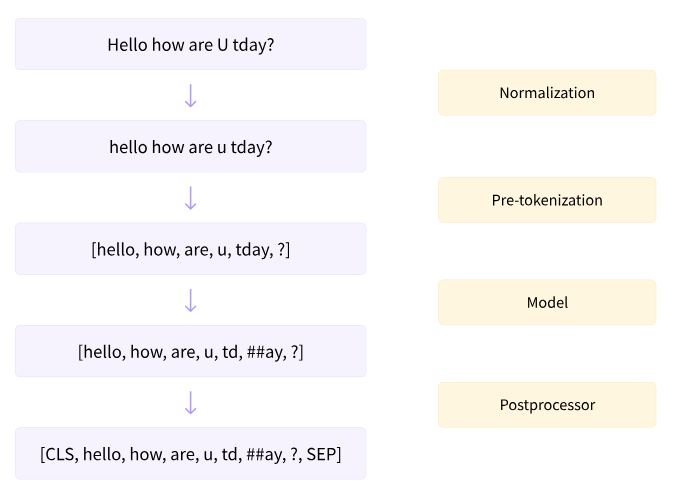

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from datasets import load_dataset # huggingface allow easy download
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

from pathlib import Path

from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'datasets'

In [ ]:
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
  sos_idx = tokenizer_tgt.token_to_id['SOS']
  eos_idx = tokenizer_tgt.token_to_id['EOS']

  # precompute the encoder output and reuse it for every token we get from the decoder
  encouder_output = model.encode(source, source_mask)

  # initialize the decoder input with the sos token
  decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source).to(device)

  while True:
    if decoder_input.size(1) == max_len:
      break

    # build mask for the target (decoder input)
    decoder_mask = causal_mask(decoder_input.size(1).type_as(source_mask)).to(device)

    # calculate the output of the decoder
    out = model.decode(encouder_output, source_mask, decoder_input, decoder_mask)

    # get the max token
    prob = model.project(out[:,1])

    #select the token with the max probability (because it is a greedy search)
    _, next_word = torch.max(prob, dim=1)

    decoder_input = torch.cat(decoder_input, torch.empty(1,1).type_as(source).fill_(next_word.item()).to(device), dim=1)

    if next_word == eos_idx:
      break

  # remove the batch dim from the output which is decoder_input
  return decoder_input.squeeze(0)


In [ ]:
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_state, write, num_examples=2):
  model.eval()
  count = 0
  console_width = 80


  with torch.no_grad():
    for batch in validation_ds:
      count += 1
      encoder_input = batch['encoder_input'].to(device)
      encoder_mask = batch['encoder_mask'].to(device)

      assert encoder_input.size(0) == 1, "Batch size must be 1 for validation"
      model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

      source_text = batch['src_text'][0]
      target_text = batch['tgt_text'][0]
      model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

      # print to console
      print_msg('-'*console_width)
      print_msg(f'SOURCE: {source_text}')
      print_msg(f'TARGET: {target_text}')
      print_msg(f'PREDICTED: {model_out_text}')

      if count == num_examples:
        break


In [ ]:
def get_all_sentences(ds, lang):
  # Generator function to extract sentences from a dataset for a specified language.
  for item in ds:
    yield item['translation'][lang]

In [ ]:
def get_or_build_tokenizer(config, ds, lang):
    """
    Retrieves an existing tokenizer or builds a new one for a specified language.

    Parameters:
        - config (Dict): Configuration dictionary containing tokenizer_file path.
        - dataset (List[Dict]): List of dictionary entries representing the dataset.
        - lang (str): Language key indicating the target language.

    Returns:
        - tokenizer (Tokenizer): Tokenizer object for the specified language.
    """

    tokenizer_path = Path(config['tokenizer_file'].format(lang))

    if not Path.exists(tokenizer_path):
      # Most code taken from: https://huggingface.co/docs/tokenizers/quicktour
      tokenizer = Tokenizer(WordLevel(unk_token='[UNK]'))
      tokenizer.pre_tokenizer = Whitespace()
      trainer = WordLevelTrainer(special_tokens=['[UNK]', '[PAD]', '[SOS]', '[EOS]'], min_frequency=2)
      tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
    else:
      tokenizer = Tokenizer.from_file(str(tokenizer_path))

    return tokenizer

In [ ]:
def get_ds(config):
  # It only has the train split, so we divide it overselves
  ds_raw = load_dataset('opus_books', f"{config['lang_src']}-{config['lang_tgt']}", split='train')
  #ds_raw = load_dataset(f"{config['datasource']}", f"{config['lang_src']}-{config['lang_tgt']}", split='train')

  # opus_books: 'en-it' (english to Italian) - 1st entry
  # {'id': '0', 'translation': {'en': 'Source: Project Gutenberg', 'it': 'Source: www.liberliber.it/Audiobook available here'}}

  # build tokenizer
  tokenizer_src = get_or_build_tokenizer(config, ds_raw, config['lang_src'])
  tokenizer_tgt = get_or_build_tokenizer(config, ds_raw, config['lang_tgt'])

  # keep train:validation = 0.9:0.1
  train_ds_size = int(0.9 * len(ds_raw))
  val_ds_size = len(ds_raw)-train_ds_size

  train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size])

  train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
  val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

  max_len_src = 0
  max_len_tgt = 0

  for item in ds_raw:
    src_ids = tokenizer_src.encode(item['translation'][config['lang_src']]).ids
    tgt_ids = tokenizer_tgt.encode(item['translation'][config['lang_tgt']]).ids
    max_len_src = max(max_len_src, len(src_ids))
    max_len_tgt = max(max_len_tgt, len(tgt_ids))

  print(f'Max length of source sentence: {max_len_src}')
  print(f'Max length of target sentence: {max_len_tgt}')

  train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
  val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)

  return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt


In [ ]:
def get_model(config, vocab_src_len, vocab_tgt_len):
  model = build_transformer(vocab_src_len, vocab_tgt_len, config ['seq_len'], config ['seq_len'], config['d_model'])
  return model

In [ ]:
def train_model(config):
  device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
  print(f'Using  device: {device}')

  Path(config['model_folder']).mkdir(parents=True, exist_ok=True)

  train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
  model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

  # tensorboard
  writer = SummaryWriter(config['experiment_name'])

  optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9)

  # store the state of model & optimizer
  initial_epoch = 0
  global_step = 0

  preload = config['preload']
  model_filename = latest_weights_file_path(config) if preload == 'latest' else get_weights_file_path(config, preload) if preload else None
  if model_filename:
    model_filename = get_weights_file_path(config, config['preload'])
    print(f'Preloading model {model_filename}')
    state = torch.load(model_filename)
    model.load_state_dict(state['model_state_dict'])
    initial_epoch = state['epoch'] + 1
    optimizer.load_state_dict(state['optimizer_state_dict'])
    global_step = state['global_step']

  # label_smoothing=0.1 => take 10% from highest probablity and give it to others
  loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1).to(device)

  for epoch in range(initial_epoch, config['num_epochs']):
    batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
    for batch in batch_iterator:
      model.train()
      encoder_input = batch['encoder_input'].to(device) # (B, seq_len)
      decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
      encoder_mask = batch['encoder_mask'].to(device)   # (B, 1, 1, seq_len)
      decoder_mask = batch['decoder_mask'].to(device)   # (B, 1, seq_len. seq_len)

      encoder_output = model.encode(encoder_input, encoder_mask) # (B, seq_len, d_model)
      decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (B, seq_len, d_model)
      proj_output = model.ProjectionLayer(decoder_output) # (B, seq_len, tgt_vocab_size)
      label = batch['label'].to(device) # (B, seq_len)

      # (B, seq_len, tgt_vocab_size) -> (B * seq_len, tgt_vocab_size)
      loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))

      batch_iterator.set_postfix({'loss': f'{loss.item():6.3f}'})

      # log to tensorboard
      writer.add_scalar('train_loss', loss.item(), global_step)
      writer.flush()

      # backprop
      loss.backward()

      # update weights
      optimizer.step()
      optimizer.zero_grad()

      global_step += 1 # used for tensorboard
    run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt,config['seq_len'], device, lambda msg: batch_iterator.write(msg), writer, global_step)

    # save model at the end of every epoch
    model_filename = get_weights_file_path(config, f'{epoch:02d}')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'global_step': global_step
    }, model_filename)


In [ ]:
# config = get_config()
# train_model(config)

</hr>
</hr>

# config.py

In [ ]:
from pathlib import Path

def get_config():
  return {
        "batch_size": 8,
        "num_epochs": 20,
        "lr": 10**-4,
        "seq_len": 350,
        "d_model": 512,
        "datasource": 'opus_books',
        "lang_src": "en",
        "lang_tgt": "it",
        "model_folder": "weights",
        "model_basename": "tmodel_",
        "preload": "latest",
        "tokenizer_file": "tokenizer_{0}.json",
        "experiment_name": "runs/tmodel"
  }

def get_weights_file_path(config, epoch:str):
  model_folder = config['model_folder']
  model_basename = config['model_basename']
  model_filename = f"{model_basename}{epoch}.pt"
  return str(Path('.') / model_folder / model_filename)

# Find the latest weights file in the weights folder
def latest_weights_file_path(config):
    model_folder = f"{config['datasource']}_{config['model_folder']}"
    model_filename = f"{config['model_basename']}*"
    weights_files = list(Path(model_folder).glob(model_filename))
    if len(weights_files) == 0:
        return None
    weights_files.sort()
    return str(weights_files[-1])

</hr>
</hr>

# dataset.py
- Functions that will convert our dataset into tensor that model can consume

In [17]:
import torch
from typing import Any

In [18]:
class BilingualDataset(Dataset):
  def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len) -> None:
    super().__init__()

    self.ds = ds
    self.tokenizer_src = tokenizer_src
    self.tokenizer_tgt = tokenizer_tgt
    self.src_lang = src_lang
    self.tgt_lang = tgt_lang
    self.seq_len = seq_len

    # Create tensor for each - SOS/EOS/PAD that will be concanated with input tensor
    # Ex: <SOD> <input tokens> <PAD> <EOS>
    self.sos_token = torch.tensor([tokenizer_src.token_to_id('[SOS]')], dtype=torch.int64)
    self.eos_token = torch.tensor([tokenizer_src.token_to_id('[EOS]')], dtype=torch.int64)
    self.pad_token = torch.tensor([tokenizer_src.token_to_id('[PAD]')], dtype=torch.int64)

  def __len__(self):
    return len(self.ds)

  def __getitem__(self, index: Any) -> Any:
    src_target_pair = self.ds[index]
    src_text = src_target_pair['translation'][self.src_lang]
    tgt_text = src_target_pair['translation'][self.tgt_lang]

    # tokenizer.encode() method to convert text to tokens
    enc_input_tokens = self.tokenizer_src.encode(src_text).ids
    dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

    enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) -2 # will add [SOS] & [EOS] so -2
    dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) -1 # in training we only add [SOS] to decode so only one. [EOS] is added to label(target)/decoder output.

    if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
      raise ValueError('Sentence is too long. Add code to truncate teh long sequences')

    # Add [SOS] and [EOS] to source text
    encoder_input = torch.cat(
        [
            self.sos_token,
            torch.tensor(enc_input_tokens, dtype=torch.int64),
            self.eos_token,
            torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64),
        ],
        dim=0
    )

    # [EOS] in decoder input because the model learns to generate <EOS>.
    #     - Target Sequence: ["Hello", "world", "[EOS]"]
    #     - Decoder Input (shifted right): ["[SOS]", "Hello", "world"]
    decoder_input = torch.cat(
        [
            self.sos_token,
            torch.tensor(dec_input_tokens, dtype=torch.int64),
            torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
        ],
        dim=0
    )

    # it has only [EOS]
    label = torch.cat(
        [
            torch.tensor(dec_input_tokens, dtype=torch.int64),
            self.eos_token,
            torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
        ],
        dim=0
    )

    assert encoder_input.size(0) == self.seq_len
    assert decoder_input.size(0) == self.seq_len
    assert label.size(0) == self.seq_len

    return {
        "encoder_input": encoder_input, # (seq_len)
        "decoder_input": decoder_input,  # (seq_len)
        "encoder_mask": (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(), # (1,1, seq_len)
        "decoder_mask": (decoder_input != self.pad_token).unsqueeze(0).int() & causal_mask(decoder_input.size(0)), # (1, seq_len) & (1, seq_len, seq_len)
        "label": label, # (seq_len)
        "srcs_text": src_text,
        "tgt_text": tgt_text
    }


def causal_mask(size):
  # diagonal=1 would retain elements on and above the first diagonal
  mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
  return mask == 0 # negate it

</hr>
</hr>

# Start training

In [19]:
config = get_config()
train_model(config)

In [ ]:
# class FeedForwardBlock(nn.Module):
#     def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
#         super().__init__()
#         # First linear transformation (input to hidden layer)
#         self.linear1 = nn.Linear(d_model, d_ff)

#         # Activation function (ReLU)
#         self.activation = nn.ReLU()

#         # Second linear transformation (hidden layer to output)
#         self.linear2 = nn.Linear(d_ff, d_model)

#         # Dropout for regularization
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = self.linear1(x) # (Batch, seq_len, d_model) -> (Batch, seq_len, d_ff)
#         x = self.activation(x)
#         x = self.dropout(x)
#         x = self.linear2(x) # (Batch, seq_len, d_ff) -> (Batch, seq_len, d_model)

#         return x